In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import requests
from pywebcopy import save_website

# Load data

In [2]:
html_file_path = 'data/raw/2021-06-02.html'
data = pd.read_html(html_file_path)

# Review data

In [3]:
next_matches_index = 0
standings_indexes = range(1,7)
goalkeepers_index = 7
defenders_index = 8
midfielders_index = 9
forwards_index = 10

In [4]:
# data[next_matches_index]

In [5]:
# data[random.randint(min(standings_indexes), max(standings_indexes))]

In [6]:
# data[random.randint(goalkeepers_index, forwards_index)]

# Data reorganize and pre-process

In [7]:
next_matches_columns_renames = {"תאריך": "date", "שעה": "hour", "קבוצה מארחת": "home_team", "תוצאה": "score", "קבוצה אורחת": "away_team", "סקירה": "review"}
next_matches_df = data[next_matches_index].rename(columns=next_matches_columns_renames)
del next_matches_df['hour']
del next_matches_df['review']
next_matches_df['date'] = pd.to_datetime(next_matches_df['date'], format="%d.%m.%Y")

In [8]:
# next_matches_df

In [9]:
standings_columns_renames = {"קבוצה": "team", "מש’": "MP", "נצ’": "W", "תיקו": "D", "הפסד": "L", "יחס": "GF-GA", "נקודות": "Pts"}
groups_standings = []
for index in standings_indexes:
    new_standing_df = data[index].rename(columns=standings_columns_renames)
    new_standing_df['GF'] = new_standing_df['GF-GA'].apply(lambda x: (x.split('-'))[0]).astype('int')
    new_standing_df['GA'] = new_standing_df['GF-GA'].apply(lambda x: (x.split('-'))[1]).astype('int')
    new_standing_df['GD'] = new_standing_df['GF'] - new_standing_df['GA']
    del new_standing_df['GF-GA']
    groups_standings.append(new_standing_df)

In [10]:
# groups_standings[random.randint(0, len(groups_standings)-1)]

In [11]:
gaolkeepers_columns_renames = {"שוער": "name", "מחיר": "price", "נק’": "points"}
gaolkeepers_df = data[goalkeepers_index].rename(columns=gaolkeepers_columns_renames)
gaolkeepers_df['position'] = 'GK'
del gaolkeepers_df['Unnamed: 3']

defenders_columns_renames = {"הגנה": "name", "מחיר": "price", "נק’": "points"}
defenders_df = data[defenders_index].rename(columns=defenders_columns_renames)
del defenders_df['Unnamed: 3']
defenders_df['position'] = 'D'

midfielders_columns_renames = {"קישור": "name", "מחיר": "price", "נק’": "points"}
midfielders_df = data[midfielders_index].rename(columns=midfielders_columns_renames)
del midfielders_df['Unnamed: 3']
midfielders_df['position'] = 'M'

forwards_columns_renames = {"התקפה": "name", "מחיר": "price", "נק’": "points"}
forwards_df = data[forwards_index].rename(columns=forwards_columns_renames)
del forwards_df['Unnamed: 3']
forwards_df['position'] = 'FW'

In [12]:
players_df = pd.concat([gaolkeepers_df, defenders_df, midfielders_df, forwards_df], ignore_index=True)
players_df['team'] = players_df['name'].apply(lambda x: ((x.split('('))[1].split(")"))[0])
players_df['name'] = players_df['name'].apply(lambda x: ((x.split('('))[0])[:-1])
players_df['price'] = players_df['price'].apply(lambda x: (x.split('.'))[0]).astype('int')

In [13]:
# players_df

# Generate random* lineup
*with constraints on formation, budget, maximum players allowed from the same team, minimal player price.

In [14]:
def get_random_lineup(players_df, formation=[4,3,3], budget=100, budget_delta=1, max_same_team=2, min_player_price=4):
    
    if sum(formation) != 10:
        print("Error: Illegal formation. Formation must sum up to 10 players.")
        return
    if (formation[0] < 3 or formation[0] > 5) or (formation[1] < 3 or formation[1] > 5)  or (formation[2] < 1 or formation[2] > 3): 
        print("Error: Illegal formation. 3 <= Defenders,Midfielders <= 5, 1 <= Forwards <= 3")
        return
    
    players_df = players_df[players_df['price'] >= min_player_price]
    
    used_budegt = 0
    same_team = 0
    while (used_budegt < budget - budget_delta) or (used_budegt > budget) or (same_team > max_same_team):
        lineup_df = pd.concat([players_df[players_df['position'] == 'GK'].sample(),
                               players_df[players_df['position'] == 'D'].sample(formation[0]),
                               players_df[players_df['position'] == 'M'].sample(formation[1]),
                               players_df[players_df['position'] == 'FW'].sample(formation[2])])
        used_budegt = lineup_df['price'].sum()
        same_team = lineup_df['team'].value_counts().max()
    
    print(f'Used budget: {used_budegt}.0M')
    return lineup_df

In [15]:
# lineup_df = get_random_lineup(players_df)
# lineup_df

In [16]:
# lineup_df = get_random_lineup(players_df, formation=[3,4,3], budget=100, budget_delta=2, max_same_team=2, min_player_price=5)
# lineup_df

# Features engineering

## Teams features
1. Average betting odds
2. Average power rankings (pr) - source: The Guardian, FIFA, Reddit and my own.
3. Form (points lost in last 6 matches)
4. Wighted sum (of all features)

In [17]:
teams_file_path = 'data/teams.csv'
teams_df = pd.read_csv(teams_file_path, encoding='utf-8')
teams_df['name_e'] = teams_df['name_e'].apply(lambda x: x.replace('\xa0', '')) # clean names

In [18]:
# teams_df

In [19]:
power_rank_columns = ["theguardian_pr", "fifa_ranking", "reddit1_pr", "reddit2_pr", "my_pr"]
teams_df['power_rank_avg'] = teams_df[power_rank_columns].mean(axis=1)
max_points = 18
teams_df['form_points_lost'] = max_points - ( 3 * teams_df['form_last6'].str.count('W') +  teams_df['form_last6'].str.count('D'))

teams_df.drop(power_rank_columns, axis='columns', inplace=True)
teams_df.drop('form_last6', axis='columns', inplace=True)

In [20]:
# teams_df

### Normalize features
* MimMax normalize (to [0,1])

In [21]:
minimum = teams_df['bets_odds'].min()
maximum = teams_df['bets_odds'].max()
teams_df['bets_odds'] = (teams_df['bets_odds'] - minimum)/(maximum - minimum)

minimum = teams_df['power_rank_avg'].min()
maximum = teams_df['power_rank_avg'].max()
teams_df['power_rank_avg'] = (teams_df['power_rank_avg'] - minimum)/(maximum - minimum)

minimum = teams_df['form_points_lost'].min()
maximum = teams_df['form_points_lost'].max()
teams_df['form_points_lost'] = (teams_df['form_points_lost'] - minimum)/(maximum - minimum)

In [22]:
teams_df

,name_h,name_e,bets_odds,power_rank_avg,form_points_lost
0,צרפת,France,0.000000,0.000000,0.153846
1,אנגליה,England,0.000716,0.162162,0.230769
2,בלגיה,Belgium,0.003110,0.090090,0.153846
3,ספרד,Spain,0.006528,0.207207,0.461538
4,גרמניה,Germany,0.006650,0.171171,0.615385
5,פורטוגל,Portugal,0.008001,0.162162,0.384615
6,איטליה,Italy,0.011643,0.171171,0.000000
7,הולנד,Netherlands,0.015511,0.351351,0.384615
8,דנמרק,Denmark,0.045775,0.297297,0.384615
9,קרואטיה,Croatia,0.060550,0.477477,0.846154


### Make features "higher is better" and calculate wighted sum feature

In [23]:
teams_df['bets_odds'] = 1 - teams_df['bets_odds']
teams_df['power_rank_avg'] = 1 - teams_df['power_rank_avg']
teams_df['form_points_lost'] = 1 - teams_df['form_points_lost']

In [24]:
w_bets_odds = 0.5
w_power_rank_avg = 0.3
w_form_points_lost = 0.2
w_power = 1.4
teams_df['wighted_sum'] = (w_bets_odds * teams_df['bets_odds']) + (w_power_rank_avg * teams_df['power_rank_avg']) + (w_form_points_lost * teams_df['form_points_lost'])
teams_df['wighted_sum'] = np.power(teams_df['wighted_sum'], w_power)

In [25]:
teams_df.describe()

,bets_odds,power_rank_avg,form_points_lost,wighted_sum
count,24.000000,24.000000,24.000000,24.000000
mean,0.758128,0.500000,0.461538,0.541921
std,0.306170,0.300420,0.290489,0.288458
min,0.000000,0.000000,0.000000,0.027573
25%,0.721771,0.274775,0.211538,0.390561
50%,0.852432,0.495495,0.500000,0.585617
75%,0.989267,0.801802,0.634615,0.766842
max,1.000000,1.000000,1.000000,0.957190


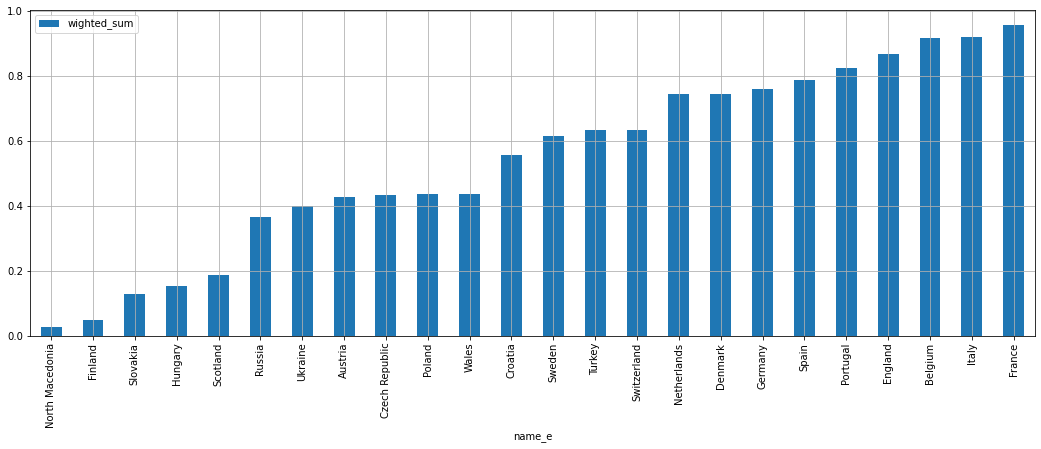

In [26]:
teams_df.sort_values("wighted_sum", inplace=True)
teams_df.plot(x="name_e", y=["wighted_sum"], kind="bar", figsize=(18,6));
plt.grid();
plt.xticks(rotation=90);

## Players features
1. Accumulated points
2. Team power rank
3. Team GF
4. Team GA
5. Team GD
6. Opponent power rank diffenrence
7. Opponent GF
8. Opponent GA
9. Opponent GD
*more features later

### Get Team power ranking, GF, GA

In [27]:
teams_wights_df = teams_df[['name_h', 'wighted_sum']].set_index('name_h')
players_df['team_pr'] = players_df.apply(lambda row: teams_wights_df.loc[row['team']], axis=1)

In [28]:
total_standings_df = pd.concat(groups_standings)
total_standings_df = total_standings_df[['team', 'GF', 'GA']].set_index('team')
players_df['team_GF'] = players_df.apply(lambda row: total_standings_df.loc[row['team']].get('GF'), axis=1)
players_df['team_GA'] = players_df.apply(lambda row: total_standings_df.loc[row['team']].get('GA'), axis=1)

### Get Opponent power ranking, GF, GA

In [29]:
opponents1_df = next_matches_df[['home_team', 'away_team']].set_index('home_team')
opponents2_df = next_matches_df[['home_team', 'away_team']].set_index('away_team')
opponents_df = pd.concat([opponents1_df, opponents2_df])
opponents_df['opponent'] = opponents_df.fillna('').sum(axis=1)
opponents_df.drop(columns=['home_team', 'away_team'], inplace=True)
players_df['opponent'] = players_df.apply(lambda row: opponents_df.loc[row['team']], axis=1)

In [30]:
players_df['opponent_pr'] = players_df.apply(lambda row: teams_wights_df.loc[row['opponent']], axis=1)

In [31]:
players_df['opponent_GF'] = players_df.apply(lambda row: total_standings_df.loc[row['opponent']].get('GF'), axis=1)
players_df['opponent_GA'] = players_df.apply(lambda row: total_standings_df.loc[row['opponent']].get('GA'), axis=1)

In [32]:
players_df

,name,price,points,position,team,team_pr,team_GF,team_GA,opponent,opponent_pr,opponent_GF,opponent_GA
0,הוגו לוריס,10,0,GK,צרפת,0.957190,0,0,גרמניה,0.760331,0,0
1,אונאי סימון,9,0,GK,ספרד,0.786374,0,0,שבדיה,0.615554,0,0
2,טיבו קורטואה,9,0,GK,בלגיה,0.917906,0,0,רוסיה,0.366186,0,0
3,מנואל נוייר,9,0,GK,גרמניה,0.760331,0,0,צרפת,0.957190,0,0
4,ג'אנלואיג'י דונארומה,8,0,GK,איטליה,0.920884,0,0,טורקיה,0.633793,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
613,מילאן ריסטובסקי,4,0,FW,צפון מקדוניה,0.027573,0,0,אוסטריה,0.427429,0,0
614,מרקוס פורס,4,0,FW,פינלנד,0.046977,0,0,דנמרק,0.745812,0,0
615,ריאן כריסטי,4,0,FW,סקוטלנד,0.187972,0,0,צ`כיה,0.432834,0,0
616,ולאטקו סטויאנובסקי,3,0,FW,צפון מקדוניה,0.027573,0,0,אוסטריה,0.427429,0,0


## More players features
* extracted from statistics of World Cup Qualifiers and Nations League metches (whoscored.com)
1. Appearances
2. Minuts played
3. Goals
4. Assists
5. Shots per Game (SpG)
6. Rating - overall performance score
7. Appearances % out of maximum number of appearances
8. Minuts played % out of maximum number Minuts played
9. Goals % out of all team's goals
10. Assists % out of all team's assists
11. Goals and Assists (GnA) % out of all team's goals and assists.

In [33]:
teams_names = teams_df['name_e'].values
teams_stats_df_dict = {}
for team in teams_names:
#     print(team)
    team_file_path = f'data/raw/teams/{team}/r1.html'
    team_data = pd.read_html(team_file_path)
    team_df = (team_data[1])[['Player.1', 'Apps', 'Mins', 'Goals', 'Assists', 'SpG', 'Rating']]
    team_df.rename(columns={"Player.1": "Player"}, inplace=True)
    team_df = team_df.replace('-', 0)
    team_df['Player'] = team_df['Player'].apply(lambda x: (x.split(',')[0])[:-3])
    team_df['Apps'] = team_df['Apps'].apply(lambda x: (x.split('(')[0]))
    teams_stats_df_dict[f'{team}'] = team_df

C:\Users\Avshalom\anaconda3\envs\fantasy\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\Avshalom\anaconda3\envs\fantasy\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\Avshalom\anaconda3\envs\fantasy\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

In [34]:
teams_stats_df_dict2 = {}
for team in teams_names:
#     print(team)
    team_file_path = f'data/raw/teams/{team}/r11.html'
    team_data = pd.read_html(team_file_path)
    team_df = (team_data[1])[['Player.1', 'Apps', 'Mins', 'Goals', 'Assists', 'SpG', 'Rating']]
    team_df.rename(columns={"Player.1": "Player"}, inplace=True)
    team_df = team_df.replace('-', 0)
    team_df['Player'] = team_df['Player'].apply(lambda x: (x.split(',')[0])[:-3])
    team_df['Apps'] = team_df['Apps'].apply(lambda x: (x.split('(')[0]))
    teams_stats_df_dict2[f'{team}'] = team_df

C:\Users\Avshalom\anaconda3\envs\fantasy\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\Avshalom\anaconda3\envs\fantasy\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\Avshalom\anaconda3\envs\fantasy\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

In [35]:
convert_dict = {'Player': str,
                'Apps': int,
                'Mins': int,
                'Goals': int,
                'Assists': int,
                'SpG': float,
                'Rating': float}

teams_stats_merged_df_dict = {}
for team in teams_names:
    df = teams_stats_df_dict[team].append(teams_stats_df_dict2[team])
    df = df.astype(convert_dict)
    grouped = df.groupby('Player').agg({'Apps': 'sum',
                                    'Mins': 'sum',
                                    'Goals': 'sum',
                                    'Assists': 'sum',
                                    'SpG': 'mean',
                                    'Rating': 'mean'})
    apps_max = grouped['Apps'].max()
    mins_max = grouped['Mins'].max()
    goals_sum = grouped['Goals'].sum()
    assists_sum = grouped['Assists'].sum()
    grouped['Apps%'] = grouped['Apps'] / apps_max
    grouped['Mins%'] = grouped['Mins'] / mins_max
    grouped['Goals%'] = grouped['Goals'] / goals_sum
    grouped['Assists%'] = grouped['Assists'] / assists_sum
    grouped['GnA%'] = (grouped['Goals'] + grouped['Assists']) / (goals_sum + assists_sum)
    teams_stats_merged_df_dict[team] = grouped


In [36]:
all_players_stats_df = pd.concat(list(teams_stats_merged_df_dict.values()))

In [37]:
players_names_df = pd.read_csv('data/players.csv', encoding='utf-8-sig')
players_names_df.drop('team', axis=1, inplace=True)

In [38]:
players_df.set_index('name', inplace=True)

In [39]:
all_players_stats_df = all_players_stats_df.merge(players_names_df, left_on=all_players_stats_df.index, right_on='name_e')
all_players_stats_df.rename(columns={'name_h': 'name'},inplace=True)
all_players_stats_df.set_index('name', inplace=True)

In [40]:
players_df = players_df.merge(all_players_stats_df, left_index=True, right_index=True)

In [41]:
players_df.to_csv('players_stats.csv', encoding='utf-8-sig')
players_df

,price,points,position,team,team_pr,team_GF,team_GA,opponent,opponent_pr,opponent_GF,...,Goals,Assists,SpG,Rating,Apps%,Mins%,Goals%,Assists%,GnA%,name_e
name,,,,,,,,,,,,,,,,,,,,,
הוגו לוריס,10,0,GK,צרפת,0.957190,0,0,גרמניה,0.760331,0,...,0,0,0.00,6.750,1.000000,1.000000,0.000000,0.0,0.000000,Hugo Lloris
אונאי סימון,9,0,GK,ספרד,0.786374,0,0,שבדיה,0.615554,0,...,0,0,0.00,6.120,0.714286,0.702028,0.000000,0.0,0.000000,Unai Simón
טיבו קורטואה,9,0,GK,בלגיה,0.917906,0,0,רוסיה,0.366186,0,...,0,0,0.00,6.385,0.444444,0.444444,0.000000,0.0,0.000000,Thibaut Courtois
מנואל נוייר,9,0,GK,גרמניה,0.760331,0,0,צרפת,0.957190,0,...,0,0,0.00,6.505,0.750000,0.736698,0.000000,0.0,0.000000,Manuel Neuer
ג'אנלואיג'י דונארומה,8,0,GK,איטליה,0.920884,0,0,טורקיה,0.633793,0,...,0,0,0.00,6.865,1.000000,1.000000,0.000000,0.0,0.000000,Gianluigi Donnarumma
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
חליל דרויסוגלו,4,0,FW,טורקיה,0.633793,0,0,איטליה,0.920884,0,...,0,0,0.00,6.030,0.000000,0.005900,0.000000,0.0,0.000000,Halil Akbunar
מרקוס פורס,4,0,FW,פינלנד,0.046977,0,0,דנמרק,0.745812,0,...,0,0,0.50,6.040,0.000000,0.079320,0.000000,0.0,0.000000,Marcus Forss
ריאן כריסטי,4,0,FW,סקוטלנד,0.187972,0,0,צ`כיה,0.432834,0,...,2,1,2.15,7.380,0.625000,0.684722,0.166667,0.1,0.136364,Ryan Christie
